# TP PROJET BIG DATA 
# G2: Horace Mendel, Charly Kenneth, Houton Sylvestre

#Importation des librairies de Python

In [ ]:
!pip install geopandas


In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split

# modèles de ML à utiliser
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# métriques pour l'évaluation
from sklearn.metrics import r2_score, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# ignorer les warnings inutiles
import warnings
warnings.filterwarnings("ignore")

2025-02-15 01:23:20.635940: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-15 01:23:20.761720: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-15 01:23:20.900255: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739579001.026799   11988 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739579001.055944   11988 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-15 01:23:21.341803: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

# Acquisition du fichier 

In [2]:
df=pd.read_csv("./Products.csv")

Les données utilisées proviennent de la base de données de la FAO FAOSTAT  

Le présent TP vise à extraire les données, explorer les données, transformer les données, construire un modele, valider le modele et présenter les résultats des prédictions pour expliquer les rendements agricoles à partir des variables de changements climatiques et de maladies des plantes

# Exploration

In [3]:
df.shape

(13837, 9)

In [4]:
df.head()

,Unnamed: 0,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp,Item_normalized
0,1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37,potatoes
1,4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37,soybeans
2,7,Albania,Potatoes,1991,77818,1485.0,121.0,15.36,potatoes
3,10,Albania,Soybeans,1991,6066,1485.0,121.0,15.36,soybeans
4,13,Albania,Potatoes,1992,82920,1485.0,121.0,16.06,potatoes


In [5]:
df.tail()

,Unnamed: 0,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp,Item_normalized
13832,28232,Zimbabwe,Sweet potatoes,2012,22222,657.0,3375.53,20.52,sweet potatoes
13833,28234,Zimbabwe,Cassava,2013,46000,657.0,2550.07,19.76,cassava
13834,28236,Zimbabwe,Potatoes,2013,165714,657.0,2550.07,19.76,potatoes
13835,28239,Zimbabwe,Soybeans,2013,13142,657.0,2550.07,19.76,soybeans
13836,28240,Zimbabwe,Sweet potatoes,2013,22222,657.0,2550.07,19.76,sweet potatoes


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13837 entries, 0 to 13836
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     13837 non-null  int64  
 1   Area                           13837 non-null  object 
 2   Item                           13837 non-null  object 
 3   Year                           13837 non-null  int64  
 4   hg/ha_yield                    13837 non-null  int64  
 5   average_rain_fall_mm_per_year  13837 non-null  float64
 6   pesticides_tonnes              13837 non-null  float64
 7   avg_temp                       13837 non-null  float64
 8   Item_normalized                13837 non-null  object 
dtypes: float64(3), int64(3), object(3)
memory usage: 973.0+ KB


In [7]:
# Supprimer les colonnes dont le nom commence par 'Unnamed'
df_cleaned = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Afficher les colonnes restantes pour vérifier
print(df_cleaned.columns)

Index(['Area', 'Item', 'Year', 'hg/ha_yield', 'average_rain_fall_mm_per_year',
       'pesticides_tonnes', 'avg_temp', 'Item_normalized'],
      dtype='object')


In [8]:
df = df_cleaned.copy()

In [9]:
df.drop(columns=['Item'], inplace=True)


In [10]:
df.to_csv('df_cleaned.csv', index=False)


In [11]:
#df=df_cleaned

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13837 entries, 0 to 13836
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Area                           13837 non-null  object 
 1   Year                           13837 non-null  int64  
 2   hg/ha_yield                    13837 non-null  int64  
 3   average_rain_fall_mm_per_year  13837 non-null  float64
 4   pesticides_tonnes              13837 non-null  float64
 5   avg_temp                       13837 non-null  float64
 6   Item_normalized                13837 non-null  object 
dtypes: float64(3), int64(2), object(2)
memory usage: 756.8+ KB


In [13]:
# Renommer les colonnes
df = df.rename(columns={
    'Item_normalized': 'Item',
    'Area': 'pays',
    'hg/ha_yield': 'rendagricole',
    'average_rain_fall_mm_per_year': 'moyplui',
    'avg_temp': 'moytemp'
})

# Afficher le DataFrame avec les nouvelles colonnes
print(df)

           pays  Year  rendagricole  moyplui  pesticides_tonnes  moytemp  \
0       Albania  1990         66667   1485.0             121.00    16.37   
1       Albania  1990          7000   1485.0             121.00    16.37   
2       Albania  1991         77818   1485.0             121.00    15.36   
3       Albania  1991          6066   1485.0             121.00    15.36   
4       Albania  1992         82920   1485.0             121.00    16.06   
...         ...   ...           ...      ...                ...      ...   
13832  Zimbabwe  2012         22222    657.0            3375.53    20.52   
13833  Zimbabwe  2013         46000    657.0            2550.07    19.76   
13834  Zimbabwe  2013        165714    657.0            2550.07    19.76   
13835  Zimbabwe  2013         13142    657.0            2550.07    19.76   
13836  Zimbabwe  2013         22222    657.0            2550.07    19.76   

                 Item  
0            potatoes  
1            soybeans  
2            po

In [14]:
# Renommer les colonnes
df = df.rename(columns={
    'hg/ha_yield': 'rendagricole',
    'year': 'annee'
 })

# Afficher le DataFrame avec les nouvelles colonnes
print(df)

           pays  Year  rendagricole  moyplui  pesticides_tonnes  moytemp  \
0       Albania  1990         66667   1485.0             121.00    16.37   
1       Albania  1990          7000   1485.0             121.00    16.37   
2       Albania  1991         77818   1485.0             121.00    15.36   
3       Albania  1991          6066   1485.0             121.00    15.36   
4       Albania  1992         82920   1485.0             121.00    16.06   
...         ...   ...           ...      ...                ...      ...   
13832  Zimbabwe  2012         22222    657.0            3375.53    20.52   
13833  Zimbabwe  2013         46000    657.0            2550.07    19.76   
13834  Zimbabwe  2013        165714    657.0            2550.07    19.76   
13835  Zimbabwe  2013         13142    657.0            2550.07    19.76   
13836  Zimbabwe  2013         22222    657.0            2550.07    19.76   

                 Item  
0            potatoes  
1            soybeans  
2            po

In [15]:
# Renommer les colonnes
df = df.rename(columns={
    'Year': 'année'
 })


In [16]:
# Renommer les colonnes
df = df.rename(columns={
    'Item': 'Cultures'
 })


In [17]:
df.isnull().sum()

pays                 0
année                0
rendagricole         0
moyplui              0
pesticides_tonnes    0
moytemp              0
Cultures             0
dtype: int64

In [18]:
#df.nunique()

In [19]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
année,13837.0,2001.538195,7.052958,1990.00,1995.0,2001.00,2008.00,2013.00
rendagricole,13837.0,123995.021970,99440.139906,50.00,30877.0,105267.00,183405.00,501412.00
moyplui,13837.0,1237.432970,720.514145,51.00,636.0,1083.00,1738.00,3240.00
pesticides_tonnes,13837.0,38919.842301,63053.653413,0.04,1597.0,17866.00,51741.99,367778.00
moytemp,13837.0,21.026373,6.166128,1.30,17.2,22.23,26.28,30.65


Nous avons un ensemble de donnéest de 13837 enregistrements et huit variables  On peut prédire les rendements à partir de cet ensemble

Description des Variables
Item_Identifier : Identifiant unique du produit.

Area:  La zone géographique (pays, région, etc.) où les données ont été collectées.  Cela pourrait être le nom d'un pays, d'une province, ou d'une autre division géographique.

Item: Le produit agricole ou alimentaire spécifique auquel les données se réfèrent.  Exemples : "patate douce", "Soja", "Pommes de terre", etc.

Year: L'année de la collecte des données.

hg/ha_yield: Le rendement de la culture, exprimé en hectogrammes par hectare (hg/ha).  Un hectogramme est égal à 100 grammes.  Cette variable indique la quantité de produit récolté par unité de surface.

average_rain_fall_mm_per_year: La pluviométrie moyenne annuelle dans la zone, mesurée en millimètres (mm).  C'est une donnée climatique importante qui influence la croissance des cultures.

pesticides_tonnes: La quantité de pesticides utilisée (en tonnes) dans la zone pendant l'année.  Cette variable reflète l'utilisation de produits phytosanitaires dans l'agriculture.

avg_temp: La température moyenne annuelle dans la zone, généralement en degrés Celsius (°C).  Comme la pluviométrie, la température est un facteur climatique crucial pour l'agriculture.

Item_normalized:  Cette variable suggère que les valeurs de "Item" ont été transformées ou normalisées.

# Visualisation

In [20]:
!pip install matplotlib

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualisation 

In [22]:
!pip install pywaffle


In [23]:
!pip install highlight-text

In [ ]:
!pip install ydata-profiling


In [24]:
import matplotlib.ticker as mtick
import seaborn as sns
import math

from datetime import datetime
from matplotlib.colors import LinearSegmentedColormap, NoNorm
from ydata_profiling import ProfileReport
from highlight_text import fig_text, ax_text

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

array([[<Axes: title={'center': 'année'}>,
        <Axes: title={'center': 'rendagricole'}>],
       [<Axes: title={'center': 'moyplui'}>,
        <Axes: title={'center': 'pesticides_tonnes'}>],
       [<Axes: title={'center': 'moytemp'}>, <Axes: >]], dtype=object)

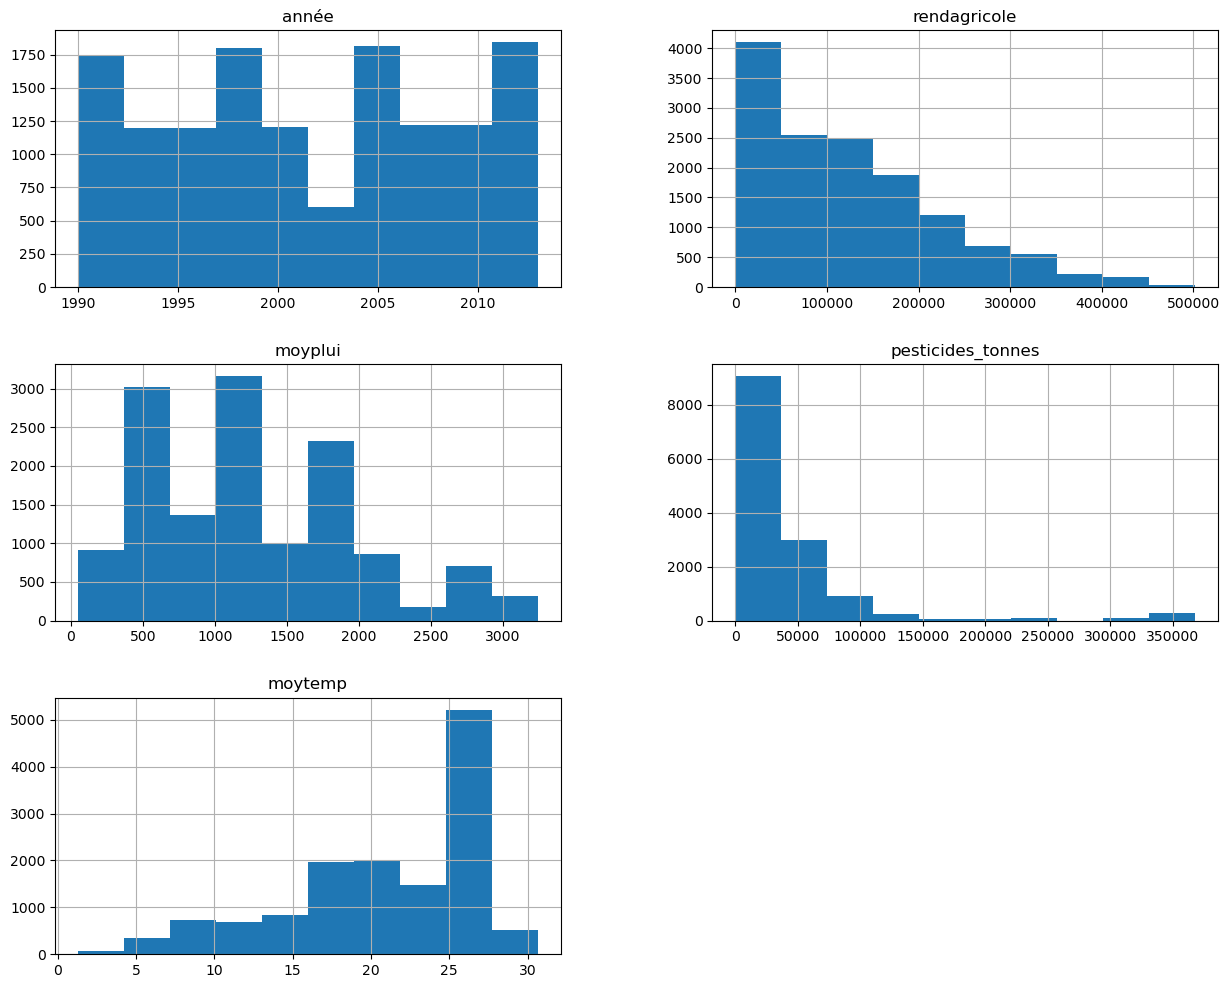

In [26]:
df.hist(figsize=(15,12))

In [27]:
df['rendagricole'] =df['rendagricole'].apply(lambda x: 1 if x == "Small" else 2 if x == "Medium" else 3 if "High" else 0)

In [28]:
df

,pays,année,rendagricole,moyplui,pesticides_tonnes,moytemp,Cultures
0,Albania,1990,3,1485.0,121.00,16.37,potatoes
1,Albania,1990,3,1485.0,121.00,16.37,soybeans
2,Albania,1991,3,1485.0,121.00,15.36,potatoes
3,Albania,1991,3,1485.0,121.00,15.36,soybeans
4,Albania,1992,3,1485.0,121.00,16.06,potatoes
...,...,...,...,...,...,...,...
13832,Zimbabwe,2012,3,657.0,3375.53,20.52,sweet potatoes
13833,Zimbabwe,2013,3,657.0,2550.07,19.76,cassava
13834,Zimbabwe,2013,3,657.0,2550.07,19.76,potatoes
13835,Zimbabwe,2013,3,657.0,2550.07,19.76,soybeans


In [29]:
# import pandas as pd
print(df)

# Nettoyer et préparer les données
df = df.dropna(subset=['rendagricole'])
df['pays'] = df['pays'].astype(str)
df['Cultures'] = df['Cultures'].astype(str)
df['rendagricole'] = df['rendagricole'].astype(float)

# Trouver le pays avec le rendement maximal pour chaque culture
df_max_yield = df.loc[df.groupby('Cultures')['rendagricole'].idxmax()]

# Créer le tableau
table = df_max_yield[['Cultures', 'pays', 'rendagricole']]
table = table.rename(columns={'rendagricole': 'Rendement maximal'})
table = table.set_index('Cultures')

# Mise en forme du tableau (facultatif)
styled_table = table.style.background_gradient(cmap='viridis')

# Afficher le tableau
print(table)
display(styled_table)

           pays  année  rendagricole  moyplui  pesticides_tonnes  moytemp  \
0       Albania   1990             3   1485.0             121.00    16.37   
1       Albania   1990             3   1485.0             121.00    16.37   
2       Albania   1991             3   1485.0             121.00    15.36   
3       Albania   1991             3   1485.0             121.00    15.36   
4       Albania   1992             3   1485.0             121.00    16.06   
...         ...    ...           ...      ...                ...      ...   
13832  Zimbabwe   2012             3    657.0            3375.53    20.52   
13833  Zimbabwe   2013             3    657.0            2550.07    19.76   
13834  Zimbabwe   2013             3    657.0            2550.07    19.76   
13835  Zimbabwe   2013             3    657.0            2550.07    19.76   
13836  Zimbabwe   2013             3    657.0            2550.07    19.76   

             Cultures  
0            potatoes  
1            soybeans  
2  

,pays,Rendement maximal
Cultures,,
cassava,Angola,3.000000
plantains and others,Bahamas,3.000000
potatoes,Albania,3.000000
soybeans,Albania,3.000000
sweet potatoes,Angola,3.000000
yams,Brazil,3.000000


In [30]:
import pandas as pd



# Nettoyage et préparation des données
# 1. Gestion des valeurs manquantes dans 'rendagricole'
df.dropna(subset=['rendagricole'], inplace=True)  # Supprimer les lignes avec NaN dans 'rendagricole'

# 2. Conversion des types de données
df['pays'] = df['pays'].astype(str)
df['Cultures'] = df['Cultures'].astype(str)
df['rendagricole'] = pd.to_numeric(df['rendagricole'], errors='coerce')  # Convertir en numérique, erreurs -> NaN
df.dropna(subset=['rendagricole'], inplace=True)  # Supprimer les NaN potentiels après conversion

# 3. Standardisation des noms de culture (si nécessaire)
df['Cultures'] = df['Cultures'].str.strip().str.lower()

# Trouver la culture avec le rendement maximal pour chaque pays
df_max_yield = df.loc[df.groupby('pays')['rendagricole'].idxmax()]

# Créer le tableau
table = df_max_yield[['pays', 'Cultures', 'rendagricole']]
table = table.rename(columns={'Cultures': 'Culture principale', 'rendagricole': 'Rendement maximal'})
table = table.set_index('pays')

# Afficher le tableau
print(table)

# Exporter le tableau vers un fichier Excel (facultatif)
table.to_excel("tableau_rendements_maximaux.xlsx")

               Culture principale  Rendement maximal
pays                                                
Albania                  potatoes                3.0
Algeria                  potatoes                3.0
Angola                    cassava                3.0
Argentina                 cassava                3.0
Armenia                  potatoes                3.0
...                           ...                ...
Ukraine                  potatoes                3.0
United Kingdom           potatoes                3.0
Uruguay                  potatoes                3.0
Zambia                    cassava                3.0
Zimbabwe                  cassava                3.0

[100 rows x 2 columns]


In [31]:
df

,pays,année,rendagricole,moyplui,pesticides_tonnes,moytemp,Cultures
0,Albania,1990,3.0,1485.0,121.00,16.37,potatoes
1,Albania,1990,3.0,1485.0,121.00,16.37,soybeans
2,Albania,1991,3.0,1485.0,121.00,15.36,potatoes
3,Albania,1991,3.0,1485.0,121.00,15.36,soybeans
4,Albania,1992,3.0,1485.0,121.00,16.06,potatoes
...,...,...,...,...,...,...,...
13832,Zimbabwe,2012,3.0,657.0,3375.53,20.52,sweet potatoes
13833,Zimbabwe,2013,3.0,657.0,2550.07,19.76,cassava
13834,Zimbabwe,2013,3.0,657.0,2550.07,19.76,potatoes
13835,Zimbabwe,2013,3.0,657.0,2550.07,19.76,soybeans


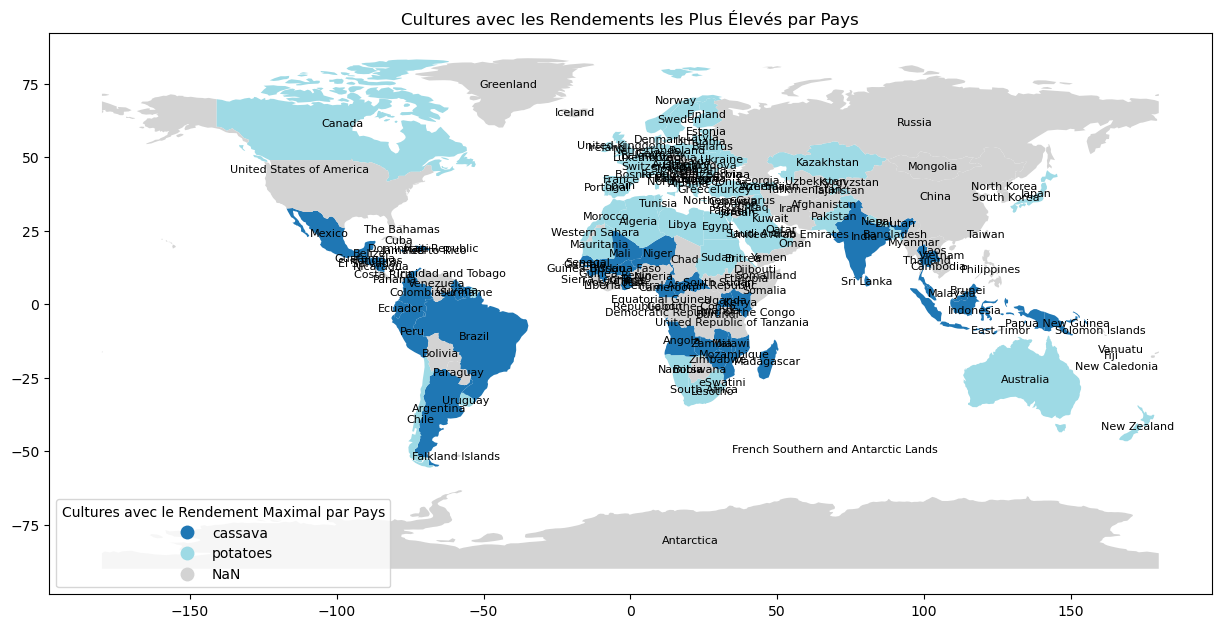

In [32]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt



# Trouver la culture avec le rendement maximal pour chaque pays
df_max_yield = df.loc[df.groupby('pays')['rendagricole'].idxmax()]

# Charger le shapefile du monde
world = gpd.read_file("./ne_110m_admin_0_countries.zip")

# Renommer la colonne pour correspondre aux noms de pays
world = world.rename(columns={'ADMIN': 'pays'})  # Ou le nom de la colonne appropriée

# Fusionner les données
world = world.merge(df_max_yield, on='pays', how='left')

# Créer la carte
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Tracer les pays avec les cultures ayant le rendement maximal
world.plot(column='Cultures',  # Utiliser la colonne 'Cultures' pour colorier
           ax=ax,
           legend=True,  # Afficher la légende
           cmap='tab20',  # Palette de couleurs distinctes pour les cultures
           legend_kwds={'title': "Cultures avec le Rendement Maximal par Pays"},  # Titre de la légende
           missing_kwds={'color': 'lightgrey'})  # Gérer les données manquantes

# Ajouter les annotations avec les noms de pays
for idx, row in world.iterrows():
    if not pd.isna(row['pays']):  # Vérifier si la valeur de 'pays' est non nulle
        plt.annotate(row['pays'], 
                     xy=(row.geometry.centroid.x, row.geometry.centroid.y), 
                     ha='center', va='center', fontsize=8, color='black')

ax.set_title('Cultures avec les Rendements les Plus Élevés par Pays')
plt.show()

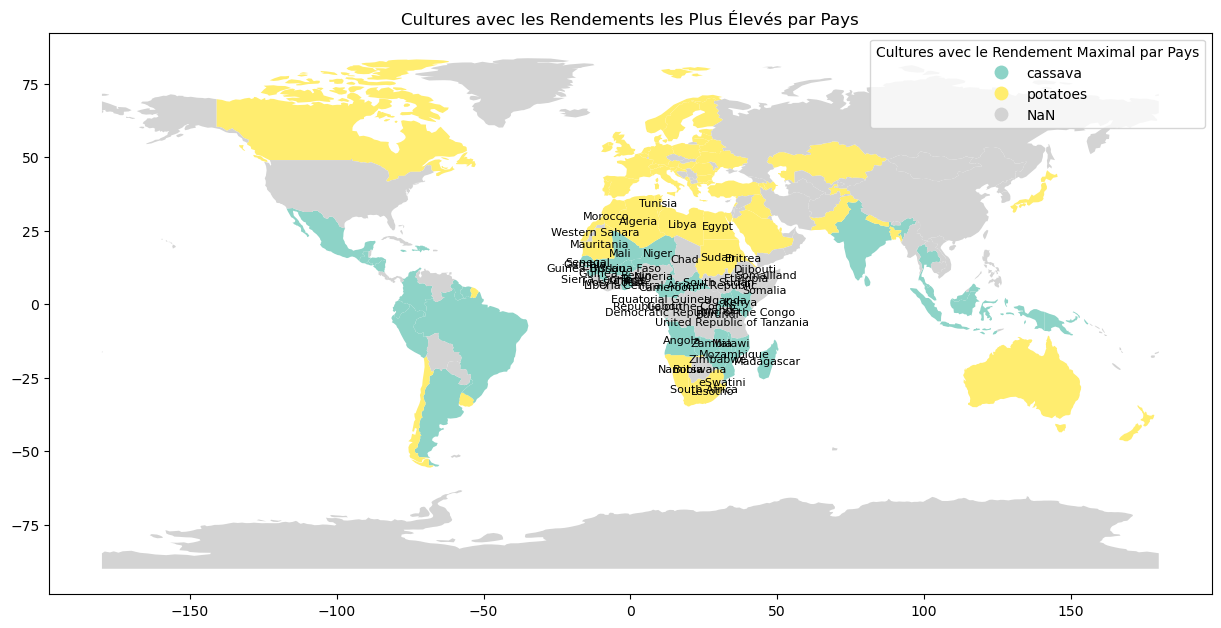

In [33]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt



# Trouver la culture avec le rendement maximal pour chaque pays
df_max_yield = df.loc[df.groupby('pays')['rendagricole'].idxmax()]

# Charger le shapefile du monde
world = gpd.read_file("./ne_110m_admin_0_countries.zip")

# Renommer la colonne pour correspondre aux noms de pays
world = world.rename(columns={'ADMIN': 'pays'})  # Ou le nom de la colonne appropriée

# Fusionner les données
world = world.merge(df_max_yield, on='pays', how='left')

# Créer la carte
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Palette de couleurs vives
cmap = plt.cm.get_cmap('Set3', len(df_max_yield['Cultures'].unique()))

# Tracer les pays avec les cultures ayant le rendement maximal
world.plot(column='Cultures',  # Utiliser la colonne 'Cultures' pour colorier
           ax=ax,
           legend=True,  # Afficher la légende
           cmap=cmap,  # Palette de couleurs vives
           legend_kwds={'title': "Cultures avec le Rendement Maximal par Pays"},  # Titre de la légende
           missing_kwds={'color': 'lightgrey'})  # Gérer les données manquantes

# Ajouter les annotations avec les noms de pays (Afrique seulement)
for idx, row in world.iterrows():
    if not pd.isna(row['pays']) and row['CONTINENT'] == 'Africa':  # Vérifier si la valeur de 'pays' est non nulle et si le pays est en Afrique
        plt.annotate(row['pays'], 
                     xy=(row.geometry.centroid.x, row.geometry.centroid.y), 
                     ha='center', va='center', fontsize=8, color='black')

ax.set_title('Cultures avec les Rendements les Plus Élevés par Pays')
plt.show()

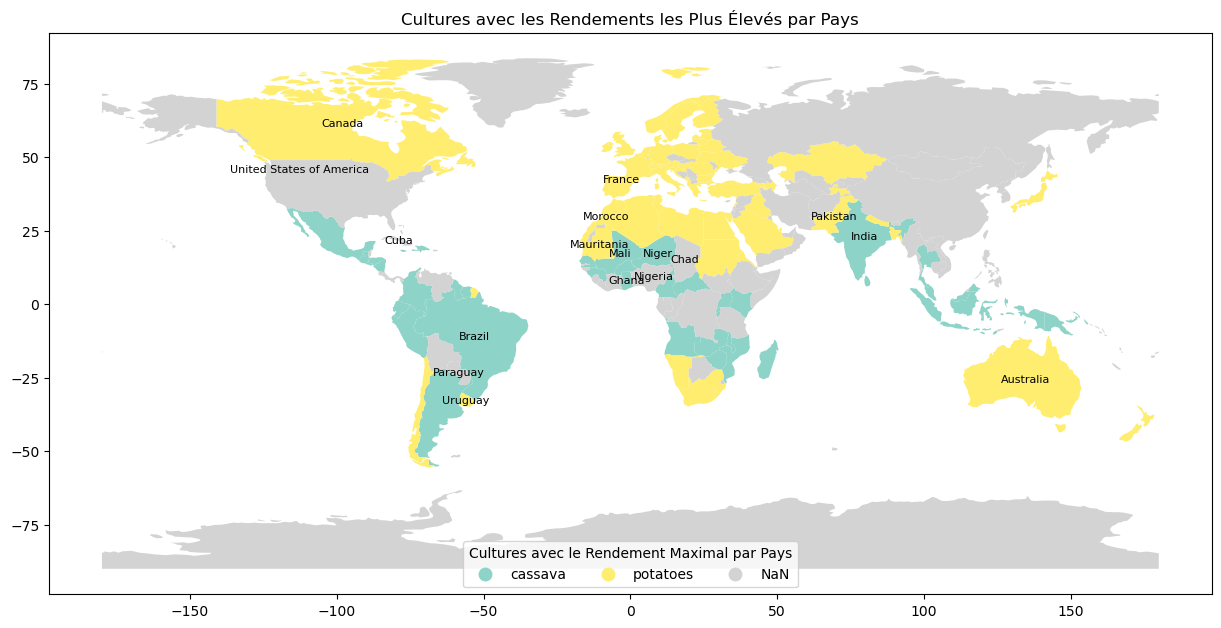

In [34]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt





# Trouver la culture avec le rendement maximal pour chaque pays
df_max_yield = df.loc[df.groupby('pays')['rendagricole'].idxmax()]

# Charger le shapefile du monde
world = gpd.read_file("./ne_110m_admin_0_countries.zip")

# Renommer la colonne pour correspondre aux noms de pays
world = world.rename(columns={'ADMIN': 'pays'})  # Ou le nom de la colonne appropriée

# Fusionner les données
world = world.merge(df_max_yield, on='pays', how='left')

# Créer la carte
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Palette de couleurs vives
cmap = plt.cm.get_cmap('Set3', len(df_max_yield['Cultures'].unique()))

# Tracer les pays avec les cultures ayant le rendement maximal
world.plot(column='Cultures',  # Utiliser la colonne 'Cultures' pour colorier
           ax=ax,
           legend=True,  # Afficher la légende
           cmap=cmap,  # Palette de couleurs vives
           legend_kwds={'title': "Cultures avec le Rendement Maximal par Pays", 'loc': 'lower center', 'ncol': 5},  # Titre de la légende, position en bas, 5 colonnes
           missing_kwds={'color': 'lightgrey'})  # Gérer les données manquantes

# Ajouter les annotations avec les noms de pays (pays spécifiques)
pays_a_garder = ['United States of America', 'Brazil', 'Argentine','Nigeria', 'Paraguay', 'Canada', 'Chad', 'SOuth Africa', 'Mauritania','France', 'Brasil','Uruguay','Chili', 'Australia', 'Cuba', 'India', 'Pakistan', 'Niger', 'Mali', 'Morocco', 'Ghana','Algérie']  # Liste des pays à garder
for idx, row in world.iterrows():
    if not pd.isna(row['pays']) and row['pays'] in pays_a_garder:  # Vérifier si la valeur de 'pays' est non nulle et si le pays est dans la liste
        plt.annotate(row['pays'], 
                     xy=(row.geometry.centroid.x, row.geometry.centroid.y), 
                     ha='center', va='center', fontsize=8, color='black')

ax.set_title('Cultures avec les Rendements les Plus Élevés par Pays')
plt.show()

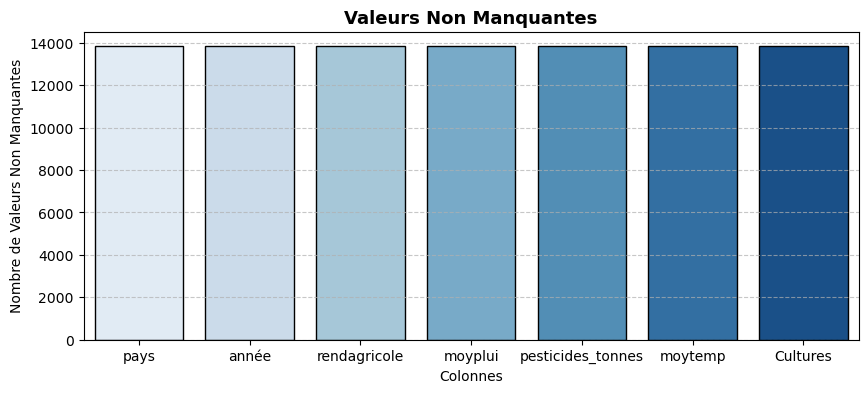

In [35]:
# DataFrame des valeurs non manquantes 
df_missing = pd.DataFrame(df.notna().sum()).reset_index() 
df_missing.columns = ['Column', 'Count']
# Créer le graphique en barres des valeurs non manquantes 
plt.figure(figsize=(10, 4)) 
sns.barplot(x='Column', y='Count', data=df_missing, palette='Blues', edgecolor="black") 
# Ajouter les étiquettes et le titre 
plt.title('Valeurs Non Manquantes', fontsize=13, weight='bold')
plt.xlabel('Colonnes', fontsize=10) 
plt.ylabel('Nombre de Valeurs Non Manquantes', fontsize=10) 
plt.grid(axis='y', linestyle='--', alpha=0.7) 
# Afficher le graphique 
plt.show()

In [36]:
df.head()

,pays,année,rendagricole,moyplui,pesticides_tonnes,moytemp,Cultures
0,Albania,1990,3.0,1485.0,121.0,16.37,potatoes
1,Albania,1990,3.0,1485.0,121.0,16.37,soybeans
2,Albania,1991,3.0,1485.0,121.0,15.36,potatoes
3,Albania,1991,3.0,1485.0,121.0,15.36,soybeans
4,Albania,1992,3.0,1485.0,121.0,16.06,potatoes


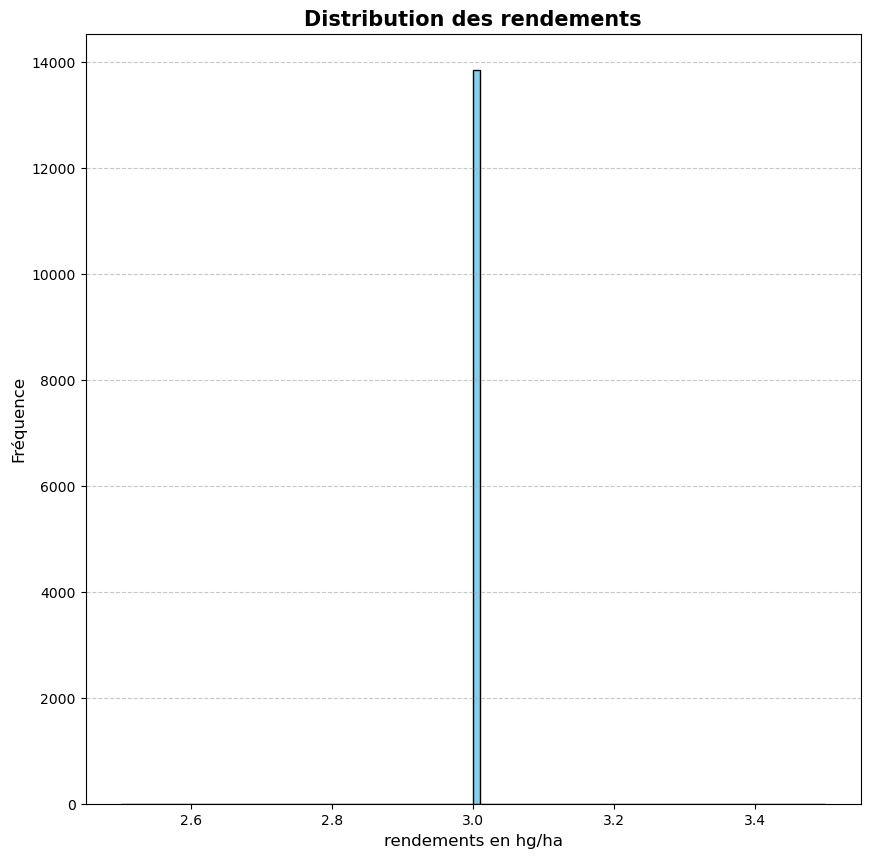

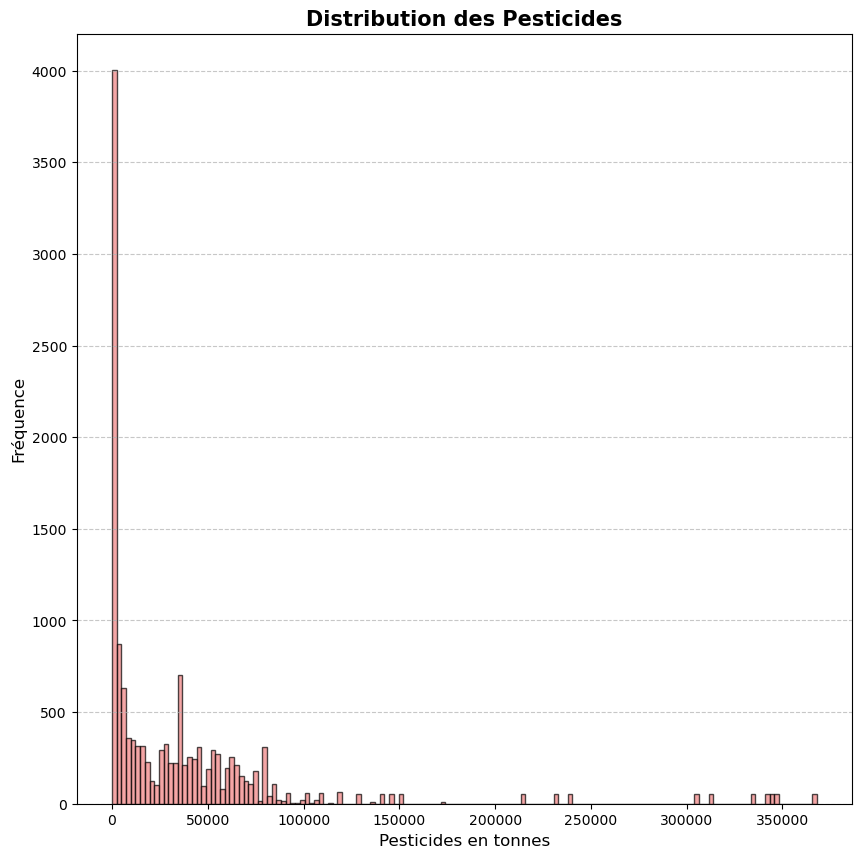

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Réglages globaux pour la taille des figures
plt.rcParams['figure.figsize'] = (10, 10)

# Histogramme des rendements
plt.hist(df["rendagricole"], bins=100, color='skyblue', edgecolor='black')
plt.title('Distribution des rendements', fontsize=15, weight='bold')
plt.xlabel('rendements en hg/ha', fontsize=12)
plt.ylabel('Fréquence', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Histogramme des pesticides
plt.hist(df["pesticides_tonnes"], alpha=0.7, bins=150, color='lightcoral', edgecolor='black')
plt.title('Distribution des Pesticides', fontsize=15, weight='bold')
plt.xlabel('Pesticides en tonnes', fontsize=12)
plt.ylabel('Fréquence', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
!pip install mpld3

In [ ]:
import mpld3

In [ ]:
plt.figure(figsize=(14,10))
sns.set_style(style='whitegrid')
plt.subplot(2,3,1)
sns.boxplot(x='rendagricole',data=df)
plt.subplot(2,3,2)
sns.boxplot(x='pesticides_tonnes',data=df)
plt.subplot(2,3,3)
sns.boxplot(x='moytemp',data=df)
plt.subplot(2,3,4)
sns.boxplot(x='moyplui',data=df)

In [ ]:
!pip install plotly

In [ ]:
import plotly.express as px
import plotly.subplots as sp
import pandas as pd



# Créer des graphiques de boîte pour chaque métrique
fig_sales = px.box(df, x="rendagricole", title="Distribution des Rendements agricoles")
fig_weight = px.box(df, x="moytemp", title="Distribution des temperatures moyennes")
fig_visibility = px.box(df, x="moyplui", title="Distribution de la pluviometrie moyenne")
fig_mrp = px.box(df, x="pesticides_tonnes", title="Distribution des quantités de pesticides")

# Combiner les quatre graphiques en une seule figure
fig = sp.make_subplots(rows=2, cols=2, subplot_titles=(
    "Distribution des Rendements agricoles", 
    "Distribution des temperatures moyennes", 
    "Distribution de la pluviometrie moyenne", 
    "Distribution des quantités de pesticides"
))

fig.add_trace(fig_sales['data'][0], row=1, col=1)
fig.add_trace(fig_weight['data'][0], row=1, col=2)
fig.add_trace(fig_visibility['data'][0], row=2, col=1)
fig.add_trace(fig_mrp['data'][0], row=2, col=2)

# Mettre à jour les mises en page pour les sous-graphiques
fig.update_layout(
    height=800, width=1200, title_text="Graphiques de Boîte des Différentes Métriques", showlegend=False
)

# Sauvegarder les graphiques dans une page HTML
fig.write_html("output_graphs_boxplots.html")

# Afficher le graphique interactif
fig.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Créer le scatter plot
fig, axes = plt.subplots(1, 1, figsize=(12, 8))
sns.scatterplot(x='rendagricole', y='pesticides_tonnes', hue='moytemp', data=df)

# Ajouter des titres et des labels
plt.title('Relation entre le rendement agricole, l\'utilisation de pesticides et la température')
plt.xlabel('Rendement agricole')
plt.ylabel('Utilisation de pesticides')
plt.legend(title='Température moyenne')

# Afficher le graphique
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Créer le scatter plot
fig, axes = plt.subplots(1, 1, figsize=(12, 8))
sns.scatterplot(x='rendagricole', y='pesticides_tonnes', hue='Cultures', data=df, palette='Set3')

# Ajouter des titres et des labels
plt.title('Relation entre le rendement agricole et les pesticides en fonction des cultures')
plt.xlabel('Rendement agricole')
plt.ylabel('pesticides en tonnes')

# Afficher le graphique
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Choisir une palette de couleurs vives et distinctes
palette = sns.color_palette("husl", len(df['Cultures'].unique()))

# Créer le scatter plot
fig, axes = plt.subplots(1, 1, figsize=(12, 8))
sns.scatterplot(x='rendagricole', y='pesticides_tonnes', hue='Cultures', data=df, palette=palette)

# Ajouter des titres et des labels
plt.title('Relation entre le rendement agricole par utilisation des pesticides pour les différentes cultures')
plt.xlabel('Rendement agricole')
plt.ylabel('Utilisation de pesticide')

# Afficher le graphique
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mpld3


# Créer le graphique de dispersion
fig, axes = plt.subplots(1, 1, figsize=(12, 8))
scatter = sns.scatterplot(x='rendagricole', y='pesticides_tonnes', hue='Cultures', data=df, ax=axes)

# Ajouter les étiquettes et le titre
axes.set_title('Relation entre les rendements, les quantites de pesticides et les cultures', fontsize=15, weight='bold')
axes.set_xlabel('Rendagricole (rendements agricoles', fontsize=12)
axes.set_ylabel('Utilisation de pesticides ', fontsize=12)

# Légende et personnalisation
scatter.legend(loc='upper right', title='Cultures')
plt.grid(True)

# Sauvegarder le graphique dans une page HTML
html_str = mpld3.fig_to_html(fig)
with open("scatter_plot_agri.html", "w") as f:
    f.write(html_str)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt



# Itérer sur chaque pays unique
for pays in df['pays'].unique():
    # Filtrer les données pour le pays actuel
    df_pays = df[df['pays'] == pays]

    # Créer le graphique pour le pays actuel
    plt.figure(figsize=(10, 6))  # Ajuster la taille de la figure si nécessaire

    # Itérer sur chaque culture unique pour le pays actuel
    for culture in df_pays['Cultures'].unique():
        # Filtrer les données pour la culture actuelle
        df_culture = df_pays[df_pays['Cultures'] == culture]

        # Tracer la courbe pour la culture actuelle
        plt.plot(df_culture['année'], df_culture['rendagricole'], label=culture)

    # Ajouter des labels et un titre
    plt.xlabel('Année')
    plt.ylabel('Rendement agricole')
    plt.title(f'Évolution annuelle des rendements agricoles pour le pays de {pays}')

    # Ajouter une légende
    plt.legend()

    #  graphique
    plt.show()

In [ ]:
# Filtrer les colonnes numériques pour la carte de corrélation 
df_corr = df.select_dtypes(include=[np.number]) 
# Créer la carte de corrélation 
fig, ax = plt.subplots(figsize=(7, 6)) 
sns.heatmap(df_corr.corr(), annot=True, cmap="Blues", linewidths=0.7, cbar=False, annot_kws={"size": 7}, ax=ax)
# Ajouter les étiquettes et le titre 
ax.set_title('Carte de Corrélation des Variables Numériques', fontsize=15, weight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10) 
plt.yticks(fontsize=10) 
plt.tight_layout() 
# Sauvegarder le graphique dans une page HTML
html_str = mpld3.fig_to_html(fig) 
with open("correlation_heatmap.html", "w") as f: f.write(html_str)
    # Afficher le graphique 
plt.show()

In [ ]:
!pip install mlxtend

In [ ]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder


# Identifier les pays qui cultivent au moins trois cultures
pays_cultures = df.groupby('pays')['Cultures'].nunique()
pays_avec_plus_de_3_cultures = pays_cultures[pays_cultures >= 3].index

# Filtrer les données pour ne garder que les pays avec au moins trois cultures
df_filtered = df[df['pays'].isin(pays_avec_plus_de_3_cultures)]

# Créer un ensemble de données transactionnelles
transactions = df_filtered.groupby('pays')['Cultures'].apply(list).tolist()

In [ ]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# Encodage des transactions
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_transactions = pd.DataFrame(te_ary, columns=te.columns_)

# Extraction des itemsets fréquents
frequent_itemsets = apriori(df_transactions, min_support=0.2, use_colnames=True)

# Génération des règles d'association
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

# Affichage des règles
print(rules)

# Suppression des colonnes inutiles
rules_to_export = rules.drop(columns=['antecedent support', 'consequent support', 'conviction', 'leverage'])


# Exportation vers Excel
rules_to_export.to_excel("regles_association.xlsx", index=False)

# Affichage des métriques dans un tableau mis en forme
print(rules[['support', 'confidence', 'lift']].describe())


In [ ]:
df

In [ ]:
data_enc = pd.get_dummies(df, columns=["pays","Cultures"], prefix = ['pays',"Cultures"])

X = data_enc.loc[:, data_enc.columns != 'rendagricole']
y = df['rendagricole']

In [ ]:
X.head()

In [ ]:
X = X.drop(['année'], axis=1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

In [ ]:
scores = []

In [ ]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

y_preds = linear_reg.predict(X_test)

In [ ]:
score = linear_reg.score(X_test, y_preds)
erreur_mae = mean_absolute_error(y_test, y_preds)
score_r2 = r2_score(y_test, y_preds)

print(f"Erreur Absolue Moyenne - MAE: {erreur_mae}")
print(f"Coéfficient R2: {score_r2}")

In [ ]:
scores.append(('Linear Regression', score, erreur_mae, score_r2))

In [ ]:
arbre_decision = DecisionTreeRegressor()
arbre_decision.fit(X_train, y_train)

y_preds = arbre_decision.predict(X_test)

In [ ]:
score = linear_reg.score(X_test, y_preds)
erreur_mae = mean_absolute_error(y_test, y_preds)
score_r2 = r2_score(y_test, y_preds)

print(f"Erreur Absolue Moyenne - MAE: {erreur_mae}")
print(f"Coéfficient R2: {score_r2}")

In [ ]:
scores.append(('Linear Regression', score, erreur_mae, score_r2))

In [ ]:
arbre_decision = DecisionTreeRegressor()
arbre_decision.fit(X_train, y_train)

y_preds = arbre_decision.predict(X_test)

In [ ]:
score = linear_reg.score(X_test, y_preds)
erreur_mae = mean_absolute_error(y_test, y_preds)
score_r2 = r2_score(y_test, y_preds)

print(f"Erreur Absolue Moyenne - MAE: {erreur_mae}")
print(f"Coéfficient R2: {score_r2}")

In [ ]:
scores.append(('Arbre de decision', score, erreur_mae , score_r2))

In [ ]:
random_f = RandomForestRegressor(n_estimators=200, max_depth=3)
random_f.fit(X_train, y_train)

y_preds = random_f.predict(X_test)

In [ ]:
score = random_f.score(X_test, y_preds)
erreur_mae = mean_absolute_error(y_test, y_preds)
score_r2 = r2_score(y_test, y_preds)

print(f"Erreur Absolue Moyenne - MAE: {erreur_mae}")
print(f"Coéfficient R2: {score_r2}")

In [ ]:
scores.append(('Random Forest', score, erreur_mae , score_r2))

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = scaler.fit_transform(X)

model_lstm = Sequential()
model_lstm.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(LSTM(32))
model_lstm.add(Dense(1))

model_lstm.compile(optimizer='adam', loss='mean_squared_error')

model_lstm.summary()

In [ ]:
model_lstm.fit(X_train, y_train, epochs=2, batch_size=64, validation_data=(X_test, y_test))

In [ ]:
y_preds = model_lstm.predict(X_test)

score = model_lstm.evaluate(X_test, y_preds)
erreur_mae = mean_absolute_error(y_test, y_preds)
score_r2 = r2_score(y_test, y_preds)

score_r2 = score_r2 if score_r2 >= 0 else score_r2 * -1

print(f"Erreur Absolue Moyenne - MAE: {erreur_mae}")
print(f"Coéfficient R2: {score_r2}")

scores.append(('LSTM model', score, erreur_mae , score_r2))

In [ ]:
scores = pd.DataFrame(scores, columns=['Nom du modèle', 'Scores', 'Erreur MAE', 'Score R2'])

In [ ]:
scores

In [ ]:
plt.figure(figsize = (6, 6))
ax = sns.barplot(y = 'Nom du modèle', x = 'Score R2', data = scores)
ax.bar_label(ax.containers[0])